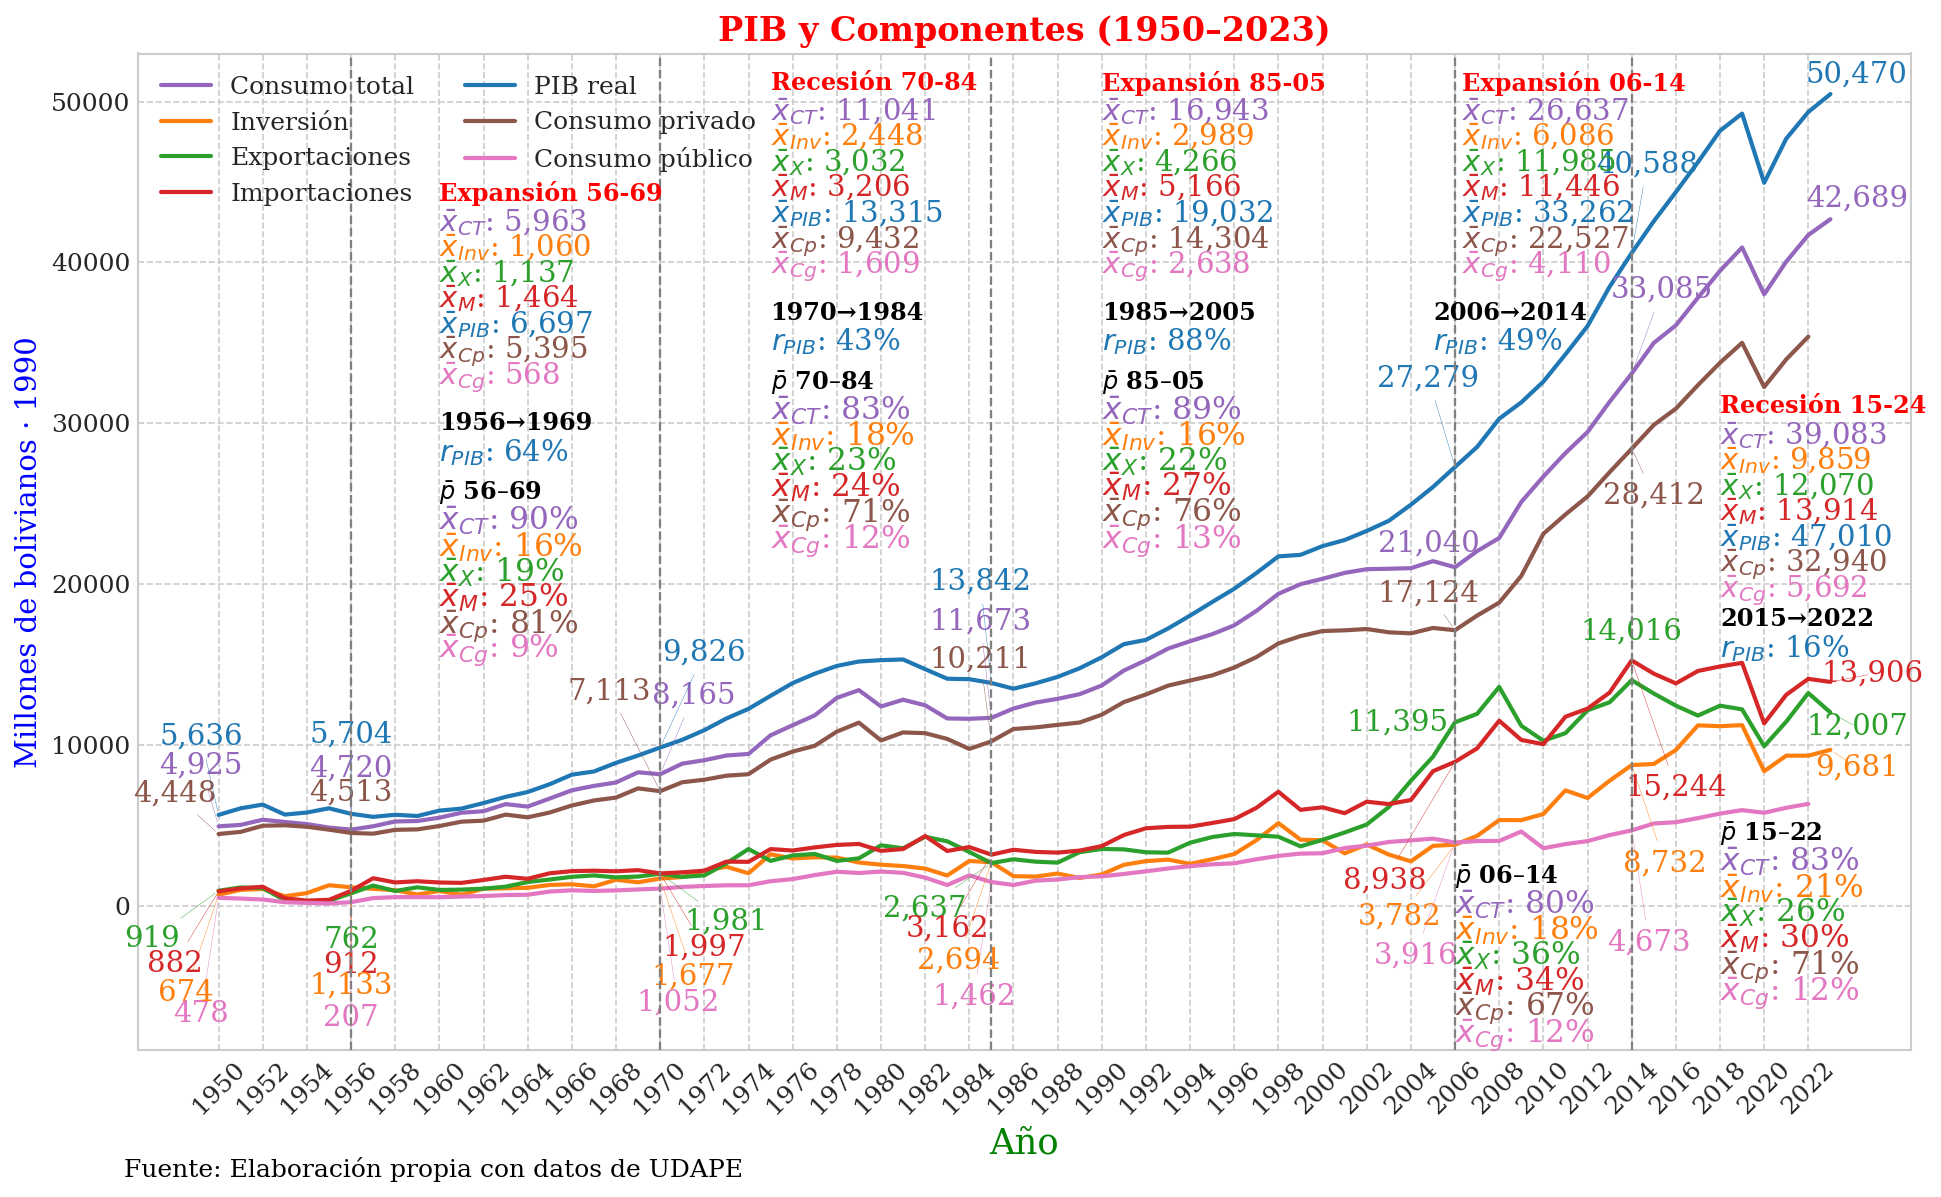

In [33]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones
# ─────────────────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os, sys
sys.path.append(os.path.abspath('../'))  # utilidades propias
from graficos_utils import *
from config import *

# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
# Dirección de salida
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)

# Estilo global de las gráficas
set_style()

# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql("SELECT * FROM pib_real_gasto", conn, index_col='año')
          .sort_index()) / 1000   # miles → millones

# ─────────────────────────────────────────────────────────────────────
# Componentes, columnas y abreviaturas
# ─────────────────────────────────────────────────────────────────────
componentes = [
    ("gastos_consumo",               "Consumo total"),
    ("formacion_capital",            "Inversión"),
    ("exportacion_bienes_servicios", "Exportaciones"),
    ("importacion_bienes",           "Importaciones"),
    ("pib_real_base_1990",           "PIB real"),
    ("consumo_privado",              "Consumo privado"),
    ("consumo_publico",              "Consumo público"),
]
cols_componentes = [col for col, _ in componentes]

abbr = {
    "gastos_consumo":               "CT",
    "formacion_capital":            "Inv",
    "exportacion_bienes_servicios": "X",
    "importacion_bienes":           "M",
    "pib_real_base_1990":           "PIB",
    "consumo_privado":              "Cp",
    "consumo_publico":              "Cg",
}

# ─────────────────────────────────────────────────────────────────────
# Preparación
# ─────────────────────────────────────────────────────────────────────
annot_years   = adjust_annot_years(df, annot_years_sin_crisis)
periodos      = adjust_periods(df, periodos_tasas_sin_crisis)

# Estadísticas por ciclo
cycle_stats = {
    name: df.loc[period, cols_componentes].mean().to_dict()
    for name, period in CYCLES_SIN_CRISIS.items()
}

# Paleta de colores
cmap = plt.get_cmap("tab10")
component_colors = {
    "gastos_consumo":               cmap(4),
    "formacion_capital":            cmap(1),
    "exportacion_bienes_servicios": cmap(2),
    "importacion_bienes":           cmap(3),
    "pib_real_base_1990":           cmap(0),
    "consumo_privado":              cmap(5),
    "consumo_publico":              cmap(6),
}

# ─────────────────────────────────────────────────────────────────────
# Offsets
# ─────────────────────────────────────────────────────────────────────
# 1) Anotaciones de valores por serie y año (sin crisis)
#    años: [1950, 1970, 1985, 2006, 2014, 2022] :contentReference[oaicite:0]{index=0}
annotation_offsets = {
    'gastos_consumo': {
        1950: (-0.8, 3800),
        1956: (0, 3800),
        1970: (1.5, 4900),
        1985: (-0.5, 6000),
        2006: (-1.2, 1500),
        2014: (1.38, 5200),
        2023: (1.2, 1300),
    },
    'formacion_capital': {
        1950: (-1.5, -6100),
        1956: (0, -6100),
        1970: (1.5, -6100),
        1985: (-1.5, -6100),
        2006: (-2.5, -4500),
        2014: (1.5, -6100),
        2023: (1.2, -1100),
    },
    'exportacion_bienes_servicios': {
        1950: (-3, -3000),
        1956: (0, -2900),
        1970: (3, -3000),
        1985: (-3, -2800),
        2006: (-2.6, 0),
        2014: (0, 3000),
        2023: (1.2, -900),
    },
    'importacion_bienes': {
        1950: (-2, -4500),
        1956: (0, -4600),
        1970: (2, -4600),
        1985: (-2, -4600),
        2006: (-3.2, -7400),
        2014: (2, -7900),
        2023: (1.9, 500),
    },
    'pib_real_base_1990': {
        1950: (-0.8, 4900),
        1956: (0, 4900),
        1970: (2, 5900),
        1985: (-0.5, 6300),
        2006: (-1.2, 5500),
        2014: (0.7, 5500),
        2023: (1.2, 1200),
    },
    'consumo_privado': {
        1950: (-2, 2500),
        1956: (0, 2500),
        1970: (-2.3, 6200),
        1985: (-0.5, 5100),
        2006: (-1.2, 2300),
        2014: (1, -2900),
        2023: (1.2, 800),
    },
    'consumo_publico': {
        1950: (-0.8, -7200),
        1956:(0,-7200), 
        1970: (0.8, -7100), 1985: (-0.8, -7100),
        2006: (-1.8, -7000), 
        2014: (0.8, -7000), 2023: (1.2, 600),
    },
}

# 2) Hitos verticales (sin crisis)
#    años: [1956, 1970, 1985, 2006, 2014] :contentReference[oaicite:1]{index=1}
hitos_offset = {
    1956: 0.45,
    1970: 0.50,
    1985: 0.50,
    2006: 0.70,
    2014: 0.55,
}

# 3) Posición de recuadros de ciclo (claves según CYCLES_SIN_CRISIS)
text_offsets = {
    "Expansión 56-69": (1960, 0.85),
    "Recesión 70-84":  (1975, 0.98),
    "Expansión 85-05": (1990, 0.98),
    "Expansión 06-14": (2006.3, 0.98),
    "Recesión 15-24":  (2018, 0.60),
}

# 4) Tasas de crecimiento por periodo (claves según periodos_tasas_sin_crisis)
#    periodos: (1956,1969),(1970,1984),(1985,2005),(2006,2014),(2015,2022) :contentReference[oaicite:2]{index=2}
period_offsets = {
    '1956-1969': (1960, 0.58),
    '1970-1984': (1975, 0.71),
    '1985-2005': (1990, 0.71),
    '2006-2014': (2005, 0.71),
    '2015-2022': (2018, 0.35),
}

# 5) Desplazamientos de participación por periodo (mismas claves que arriba)
participation_offsets = {
    "1956-1969": (1960, 0.50),
    "1970-1984": (1975, 0.63),
    "1985-2005": (1990, 0.63),
    "2006-2014": (2006, 0.05),
    "2015-2022": (2018, 0.10),
}

# ─────────────────────────────────────────────────────────────────────
# Gráfica
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=component_colors,
    title=f"PIB y Componentes ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de bolivianos · 1990",
    source_text="Fuente: Elaboración propia con datos de UDAPE",
    legend_ncol=2,
    legend_fontsize=12,
)

# Hitos verticales
add_hitos(ax, df.index, hitos_v_sin_crisis, hitos_offset)

# Anotaciones de valores por año
add_year_value_annotations(
    ax, df, annot_years, cols_componentes,
    annotation_offsets, component_colors, arrow_lw=0.2
)

# Cuadros de medias por ciclo
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, text_offsets,
    abbr, component_colors, line_spacing
)

# Tasas de crecimiento por periodo (solo PIB real)
add_period_growth_annotations_multi(
    ax, df, periodos,
    cols=['pib_real_base_1990'],
    period_offsets=period_offsets,
    colors=component_colors,
    abbr_map={'pib_real_base_1990': 'PIB'},
)

# Cuadros de participación por ciclo
add_participation_cycle_boxes(
    ax, df, periodos,
    ['gastos_consumo', 'formacion_capital', 'exportacion_bienes_servicios',
     'importacion_bienes', 'consumo_privado', 'consumo_publico'],
    'pib_real_base_1990',
    participation_offsets, abbr, component_colors
)
ax.set_ylim(-9000, df.max().max() * 1.05)

plt.savefig(os.path.join(output_dir, "pib_componentes_sin_crisis.png"))
plt.show()



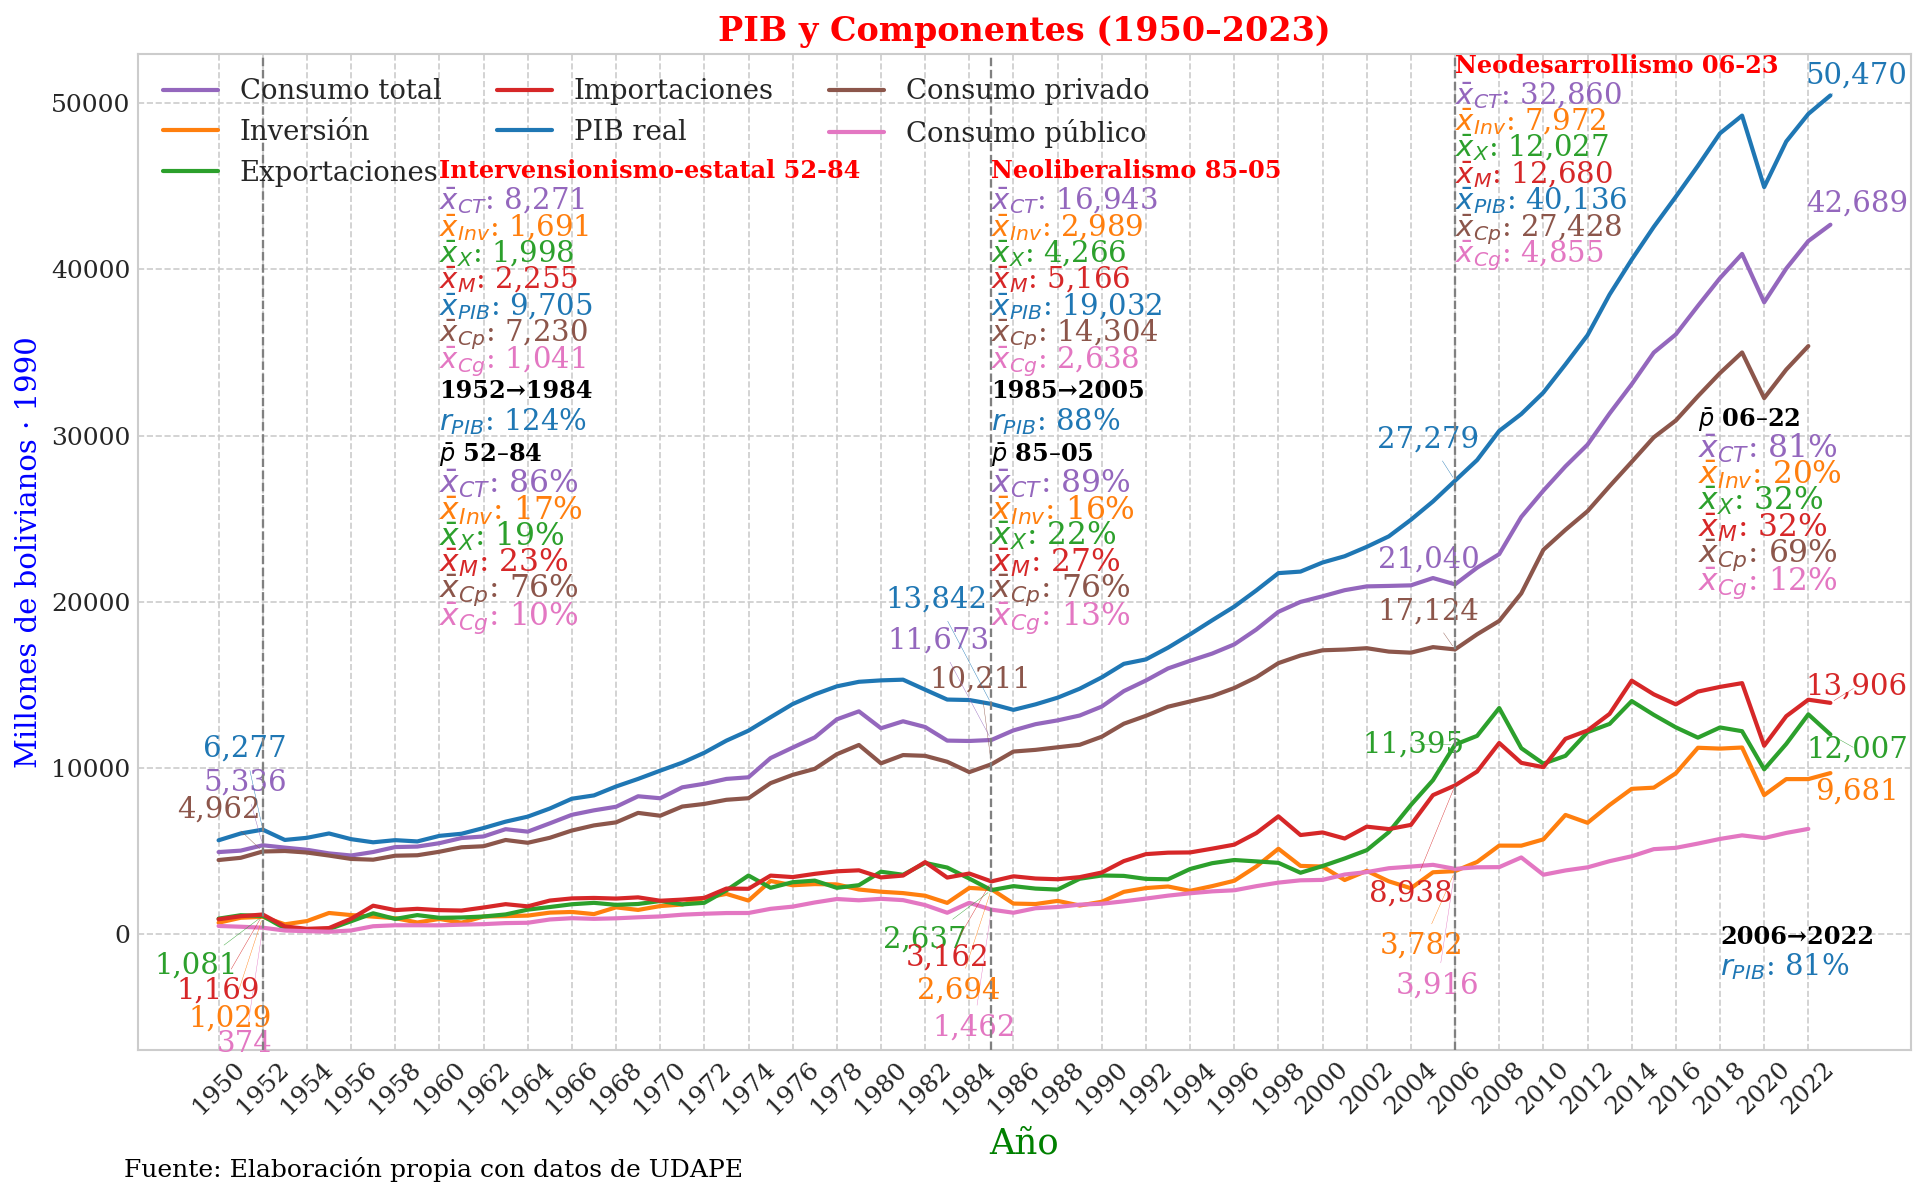

In [61]:

CYCLES_PERIODOS=adjust_cycles(df,CYCLES_PERIODOS)
cycle_stats_periodos = {
    name: df.loc[period].mean().to_dict()
    for name, period in CYCLES_PERIODOS.items()
}
annot_years_periodos= adjust_annot_years(df, annot_years_periodos)
periodos_tasas_periodos = adjust_periods(df, periodos_tasas_periodos)
# ── Offsets para Gráfica 3: Periodos estructurales ────────────────────

# Anotaciones de valores por rama y año
# 1) Anotaciones de valores por rama y año (sin cambios en años internos)
annotation_offsets_periodos = {
    "gastos_consumo": {
        1952: (-0.8,  3800),
        1985: (-2.4,  6000),
        2006: (-1.2, 1500),
        2023: (1.2,   1300),
    },
    "formacion_capital": {
        1952: (-1.5, -6100),
        1985: (-1.5, -6100),
        2006: (-1.5, -4500),
        2023: (1.2,  -1100),
    },
    "exportacion_bienes_servicios": {
        1952: (-3,   -3000),
        1985: (-3,   -3000),
        2006: (-1.9,     0),
        2023: (1.2,   -900),
    },
    "importacion_bienes": {
        1952: (-2,   -4600),
        1985: (-2,   -4600),
        2006: (-2,   -6500),
        2023: (1.2,   1000),
    },
    "pib_real_base_1990": {
        1952: (-0.8,  4900),
        1985: (-2.5,  6300),
        2006: (-1.2,  2500),
        2023: (1.2,   1200),
    },
    "consumo_privado": {
        1952: (-2,    2500),
        1985: (-0.5,  5100),
        2006: (-1.2, 2300),
        2023: (1.2,    800),
    },
    "consumo_publico": {
        1952: (-0.8, -7000),
        1985: (-0.8, -7100),
        2006: (-0.8, -7000),
        2023: (1.2,    600),
    },
}

# 2) Hitos verticales (solo años en hitos_v_periodos)
hitos_offset_periodos = {
    1952: 0.45,
    1985: 0.50,
    2006: 0.50,
}

# 3) Posición de recuadros de “medias” (claves en CYCLES_PERIODOS)
medias_offsets_periodos = {
    "Intervensionismo-estatal 52-84": (1960, 0.88),
    "Neoliberalismo 85-05":           (1985, 0.88),
    "Neodesarrollismo 06-23":         (2006, 1),
}

# 4) Posición de etiquetas de tasa de crecimiento (claves en periodos_tasas_periodos)
tasas_offsets_periodos = {
    "1952-1984": (1960, 0.63),
    "1985-2005": (1985, 0.63),
    "2006-2022": (2018, 0.01),
}

# 5) Desplazamientos de cajas de participación (mismas claves anteriores)
participation_offsets_periodos = {
    "1952-1984": (1960, 0.56),
    "1985-2005": (1985, 0.56),
    "2006-2022": (2017, 0.6),
}

# ── 5. Crear figura y trazar ────────────────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=component_colors,
    title=f"PIB y Componentes ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de bolivianos · 1990",
    source_text="Fuente: Elaboración propia con datos de UDAPE"
)
# ── 6. Dibujar líneas verticales de hitos ───────────────────────────
add_hitos(ax, df.index, hitos_v_periodos, hitos_offset)
#7 anotaciones
add_year_value_annotations(
    ax,
    df,
    years=annot_years_periodos,
    columnas=[col for col, _ in componentes],
    annotation_offsets=annotation_offsets_periodos,
    colors=component_colors,
    arrow_lw=0.2
)
add_period_growth_annotations_multi(
    ax, df, periodos_tasas_periodos,
    cols=['pib_real_base_1990'],
    period_offsets=tasas_offsets_periodos,
    colors=component_colors,
    abbr_map={'pib_real_base_1990': 'PIB'},
)

# ── 8.4 Ubicar y colorear estadísticas dentro de la gráfica ────────────
y_max = ax.get_ylim()[1]
# distancia vertical entre líneas de texto (en unidades de datos)
line_spacing = y_max * 0.030


add_cycle_means_multi(
    ax,
    cycle_stats_periodos,
    text_offsets=medias_offsets_periodos,
    abbr_map=abbr,
    colors=component_colors,
    line_spacing=line_spacing
)
add_participation_cycle_boxes(
    ax,
    df,
    periodos_tasas_periodos,
    [ 'gastos_consumo', 'formacion_capital', 'exportacion_bienes_servicios', 'importacion_bienes', 'consumo_privado', 'consumo_publico'],
    'pib_real_base_1990',
    participation_offsets_periodos,
    abbr,
    component_colors,
)

ax.set_ylim(-7000, df.max().max() * 1.05)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pib_componentes_periodos.png"))
plt.show()



In [3]:
CYCLES_PERIODOS

{'Intervensionismo-estatal 52-84': slice(1952, 1984, None),
 'Neoliberalismo 85-05': slice(1985, 2005, None),
 'Neodesarrollismo 06-23': slice(2006, 2023, None)}